In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [7]:
#ONLY FOR COLLAB RUNTIME
%load_ext tensorboard
%tensorflow_version 1.x

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [8]:
#ONLY FOR COLLAB RUNTIME
!pip install stable-baselines[mpi]==2.10.1 --quiet
!pip install pyvirtualdisplay
!pip install procgen --quiet
!pip install gym --quiet
!pip install gym3 --quiet
!pip install tensorflow-gpu==1.15.2 --quiet

In [9]:
import sys
sys.path.append('/content/gdrive/MyDrive/CSW182 Final')
#sys.path.append('/content/gdrive/Sharedwithme/CSW182 Final')

In [10]:
import imageio
import time
import numpy as np
import base64
import IPython
import PIL.Image
import pyvirtualdisplay
import pickle

# Video 
from pathlib import Path
from IPython import display as ipythondisplay

# Stable baselines

from helpers import record
from ImpalaCnn import ImpalaCnn

from stable_baselines import PPO2
from stable_baselines.common.evaluation import evaluate_policy
from gym3 import ToGymEnv, ViewerWrapper, ExtractDictObWrapper
from stable_baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from procgen import ProcgenGym3Env

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [11]:
from gym3 import ToGymEnv, ViewerWrapper, ExtractDictObWrapper
from procgen import ProcgenGym3Env

#logs_base_dir = './runs' # Log DIR for tensorboard
env_id = 'fruitbot'
env = ProcgenGym3Env(num=1, env_name=env_id, distribution_mode='easy', num_levels=500)
env = ExtractDictObWrapper(env, key="rgb")
states = env.callmethod("get_state")
pickle.dump(states, open('/content/gdrive/MyDrive/CSW182 Final/500FruitBot/500env.pickle', 'wb'))
env = ToGymEnv(env)

In [12]:
model = PPO2(ImpalaCnn, env, verbose=0, n_steps = 2048, nminibatches=8) 





Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





In [13]:
import matplotlib.pyplot as plt

def run_training(model, steps_per_round=100000,limit=10):
# This function will run a training with value set in `steps_per_round`
# after each round it will measure it's value, If value is under `limit` it will keep training until score limit is reached.  
  steps_total = 0
  score = 0
  best_score = -10000
  score_array = []
  timestep_array = []

  while score < limit:
      steps_total = steps_total + steps_per_round
      model.learn(total_timesteps=steps_per_round)

      new_evaluation = evaluate_policy(model, env, n_eval_episodes=100, deterministic=True, render=False, callback=None, reward_threshold=None, return_episode_rewards=False)
      score = new_evaluation[0]
      timestep_array.append(steps_total)
      score_array.append(score)
      pickle.dump(score_array, open('/content/gdrive/MyDrive/CSW182 Final/500FruitBot/500score_array.pickle', 'wb'))
      pickle.dump(timestep_array, open( '/content/gdrive/MyDrive/CSW182 Final/500FruitBot/500timestep_array.pickle', 'wb'))
      model.save('/content/gdrive/MyDrive/CSW182 Final/500FruitBot/500ppo2_impala.checkpoint')

      if score > best_score:
        best_score = score
        model.save('/content/gdrive/MyDrive/CSW182 Final/500FruitBot/500ppo2_impala.best')
        #record(model, length=1000) # uncomment to show video from each round
      print('steps_total: ' + str(steps_total))
      print("Mean reward:", score )
    

  # Threshold reached > evaluate over 100 episodes > Video rec/display
  print("Reward limit achived, measuring over 100ep & recording video, please wait...")
  record(model, length=1000)
  ep100 = evaluate_policy(model, env, n_eval_episodes=100, deterministic=True, render=False, callback=None, reward_threshold=None, return_episode_rewards=False)
  print("Mean Reward 100 Episodes: ", ep100[0])
  plt.plot(timestep_array, score_array)
  plt.title('Training Reward for 500 Level Environment')
  plt.xlabel('Total Timesteps')
  plt.ylabel('Mean reward over 100 different levels')

steps_total: 100000
Mean reward: -0.32
steps_total: 200000
Mean reward: 0.26
steps_total: 300000
Mean reward: 0.29
steps_total: 400000
Mean reward: 1.14
steps_total: 500000
Mean reward: 1.33
steps_total: 600000
Mean reward: 3.27
steps_total: 700000
Mean reward: 3.92
steps_total: 800000
Mean reward: 7.78
steps_total: 900000
Mean reward: 11.15
Reward limit achived, measuring over 100ep & recording video, please wait...


Mean Reward 100 Episodes:  11.57


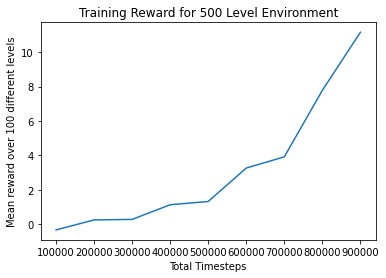

In [14]:
run_training(model)

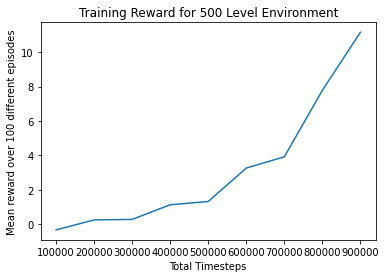

In [15]:
timestep_array = pickle.load(open( '/content/gdrive/MyDrive/CSW182 Final/500FruitBot/500timestep_array.pickle', 'rb'))
score_array = pickle.load(open('/content/gdrive/MyDrive/CSW182 Final/500FruitBot/500score_array.pickle', 'rb'))
plt.plot(timestep_array, score_array)
plt.title('Training Reward for 500 Level Environment')
plt.xlabel('Total Timesteps')
plt.ylabel('Mean reward over 100 different episodes')
plt.show()